# 🌿 Plant Disease Detection Model - Training Notebook

## Proyecto: Detección de Enfermedades en Hojas de Manzano
### Dataset: Plant Pathology 2020 - FGVC7 (Kaggle)

**Objetivo:** Entrenar un modelo de clasificación de imágenes para detectar 4 clases:
- 🟢 **Healthy** (Saludable)
- 🟠 **Rust** (Roya - Gymnosporangium)
- 🟣 **Scab** (Sarna - Venturia inaequalis)
- 🔴 **Multiple Diseases** (Múltiples enfermedades)

**Arquitectura:** EfficientNetB0 con Transfer Learning

**Output:** Modelo TensorFlow.js (GraphModel) para inferencia server-side

---
**Autor:** Daniel Fidalgo Millán
**Fecha:** Enero 2026  
**Unit 25 - Applied Machine Learning**

## 1. Configuración del Entorno

In [ ]:
# Verificar GPU disponible
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

# Configurar memoria GPU para evitar OOM
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Configuradas {len(gpus)} GPU(s) con memory growth")
    except RuntimeError as e:
        print(e)

TensorFlow version: 2.19.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Configuradas 1 GPU(s) con memory growth


In [ ]:
# Instalar dependencias necesarias
!pip install -q tensorflowjs==4.17.0
!pip install -q kaggle
!pip install -q scikit-learn
!pip install -q seaborn

In [ ]:
# Importar librerías
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import json
from datetime import datetime

# TensorFlow y Keras
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.utils.class_weight import compute_class_weight

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Semilla para reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 2. Descarga del Dataset desde Kaggle

In [ ]:
# Configurar Kaggle API
# IMPORTANTE: Sube tu archivo kaggle.json o configura las credenciales manualmente

# Opción 1: Subir kaggle.json desde tu computadora
from google.colab import files

# Crear directorio .kaggle si no existe
!mkdir -p ~/.kaggle

print("Por favor, sube tu archivo kaggle.json:")
print("(Descárgalo desde https://www.kaggle.com/settings -> API -> Create New Token)")

try:
    uploaded = files.upload()
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("✅ Kaggle API configurada correctamente")
except:
    print("⚠️ Si ya tienes configurado Kaggle, ignora este paso")

Por favor, sube tu archivo kaggle.json:
(Descárgalo desde https://www.kaggle.com/settings -> API -> Create New Token)


Saving kaggle.json to kaggle.json
✅ Kaggle API configurada correctamente


In [ ]:
# Descargar dataset Plant Pathology 2020
DATASET_NAME = "plant-pathology-2020-fgvc7"
DATA_DIR = "/content/plant-pathology-2020"

if not os.path.exists(DATA_DIR):
    print(f"Descargando dataset {DATASET_NAME}...")
    !kaggle competitions download -c {DATASET_NAME} -p {DATA_DIR}
    !unzip -q {DATA_DIR}/*.zip -d {DATA_DIR}
    print("✅ Dataset descargado y extraído")
else:
    print("✅ Dataset ya existe")

# Verificar archivos
print("\nArchivos en el directorio:")
!ls -la {DATA_DIR}

✅ Dataset ya existe

Archivos en el directorio:
total 798184
drwxr-xr-x 3 root root      4096 Jan 13 16:13 .
drwxr-xr-x 1 root root      4096 Jan 13 16:30 ..
drwxr-xr-x 2 root root    135168 Jan 13 16:13 images
-rw-r--r-- 1 root root 817072693 Mar  9  2020 plant-pathology-2020-fgvc7.zip
-rw-r--r-- 1 root root     53565 Mar  9  2020 sample_submission.csv
-rw-r--r-- 1 root root     17109 Mar  9  2020 test.csv
-rw-r--r-- 1 root root     33534 Mar  9  2020 train.csv


## 3. Análisis Exploratorio de Datos (EDA)

In [ ]:
# Cargar datos de entrenamiento
IMAGES_DIR = os.path.join(DATA_DIR, "images")
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))

print("📊 Información del Dataset:")
print(f"Total de muestras: {len(train_df)}")
print(f"\nColumnas: {train_df.columns.tolist()}")
print(f"\nPrimeras filas:")
train_df.head(10)

📊 Información del Dataset:
Total de muestras: 1821

Columnas: ['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']

Primeras filas:


image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0
5  Train_5        1                  0     0     0
6  Train_6        0                  1     0     0
7  Train_7        0                  0     0     1
8  Train_8        0                  0     0     1
9  Train_9        1                  0     0     0

In [ ]:
# Definir clases y colores
CLASS_NAMES = ['healthy', 'multiple_diseases', 'rust', 'scab']
CLASS_COLORS = ['#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']
CLASS_LABELS_ES = ['Saludable', 'Múltiples', 'Roya', 'Sarna']

# Calcular distribución de clases
class_distribution = {
    'healthy': train_df['healthy'].sum(),
    'multiple_diseases': train_df['multiple_diseases'].sum(),
    'rust': train_df['rust'].sum(),
    'scab': train_df['scab'].sum()
}

print("📈 Distribución de Clases:")
for cls, count in class_distribution.items():
    pct = (count / len(train_df)) * 100
    print(f"  {cls}: {count} ({pct:.1f}%)")

📈 Distribución de Clases:
  healthy: 516 (28.3%)
  multiple_diseases: 91 (5.0%)
  rust: 622 (34.2%)
  scab: 592 (32.5%)


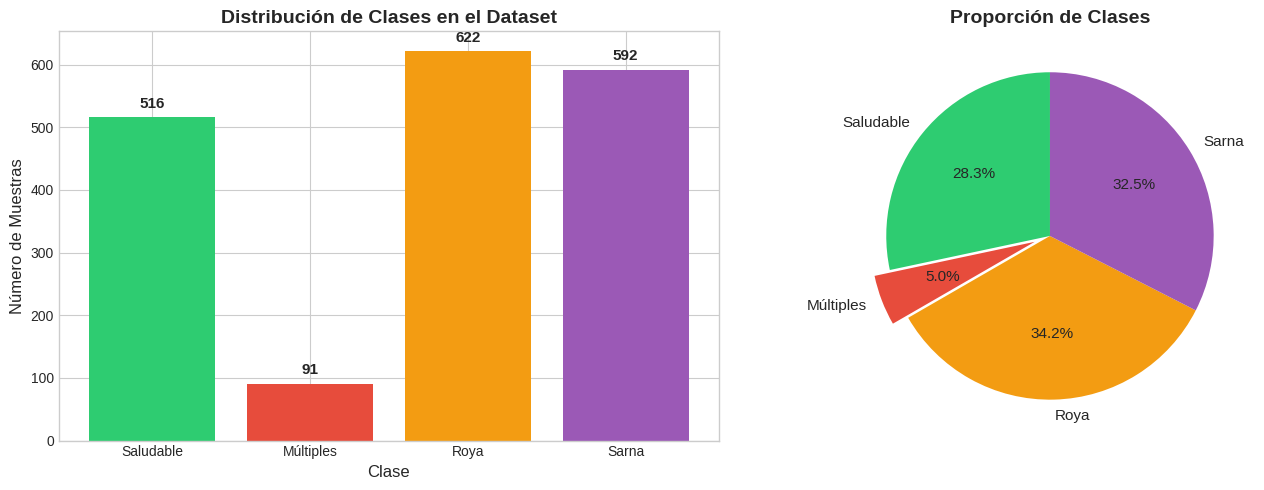


⚠️ NOTA: La clase 'multiple_diseases' está muy desbalanceada (solo 5%)
   Se aplicarán técnicas de balanceo: Class Weights + Data Augmentation


In [ ]:
# Visualizar distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
ax1 = axes[0]
bars = ax1.bar(CLASS_LABELS_ES, list(class_distribution.values()), color=CLASS_COLORS)
ax1.set_xlabel('Clase', fontsize=12)
ax1.set_ylabel('Número de Muestras', fontsize=12)
ax1.set_title('Distribución de Clases en el Dataset', fontsize=14, fontweight='bold')

# Añadir valores sobre las barras
for bar, val in zip(bars, class_distribution.values()):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             str(val), ha='center', va='bottom', fontsize=11, fontweight='bold')

# Gráfico circular
ax2 = axes[1]
explode = (0, 0.1, 0, 0)  # Destacar multiple_diseases
wedges, texts, autotexts = ax2.pie(
    list(class_distribution.values()),
    labels=CLASS_LABELS_ES,
    colors=CLASS_COLORS,
    explode=explode,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 11}
)
ax2.set_title('Proporción de Clases', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n⚠️ NOTA: La clase 'multiple_diseases' está muy desbalanceada (solo 5%)")
print("   Se aplicarán técnicas de balanceo: Class Weights + Data Augmentation")

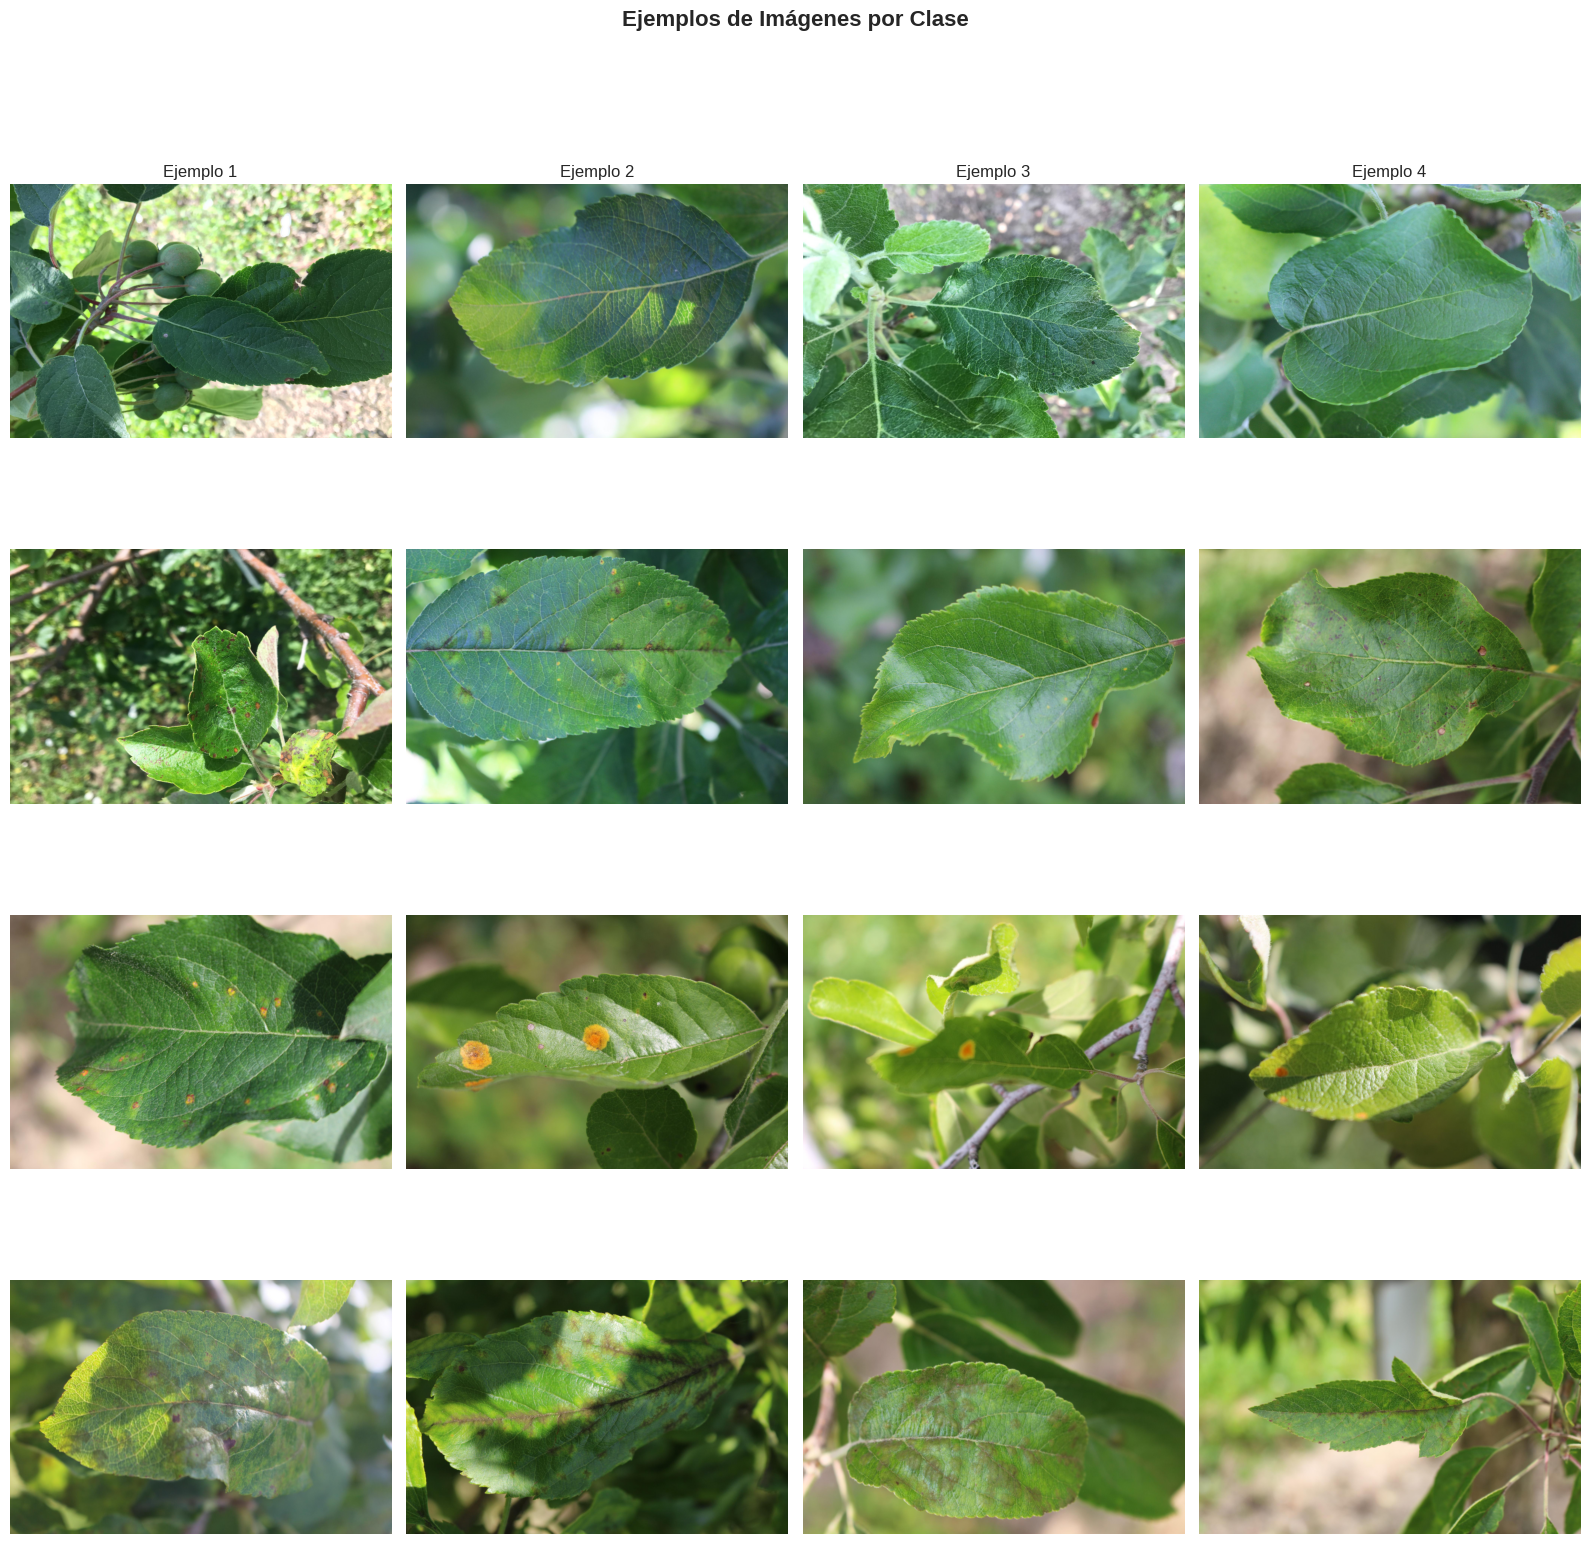

In [ ]:
# Visualizar ejemplos de cada clase
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for row, class_name in enumerate(CLASS_NAMES):
    # Obtener muestras de esta clase
    class_samples = train_df[train_df[class_name] == 1].sample(n=4, random_state=SEED)

    for col, (_, sample) in enumerate(class_samples.iterrows()):
        img_path = os.path.join(IMAGES_DIR, f"{sample['image_id']}.jpg")
        img = Image.open(img_path)

        ax = axes[row, col]
        ax.imshow(img)
        ax.axis('off')

        if col == 0:
            ax.set_ylabel(CLASS_LABELS_ES[row], fontsize=14, fontweight='bold')
        if row == 0:
            ax.set_title(f"Ejemplo {col+1}", fontsize=12)

plt.suptitle('Ejemplos de Imágenes por Clase', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('/content/sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Analizar dimensiones de las imágenes
sample_images = train_df.sample(n=100, random_state=SEED)
image_sizes = []

for _, row in sample_images.iterrows():
    img_path = os.path.join(IMAGES_DIR, f"{row['image_id']}.jpg")
    with Image.open(img_path) as img:
        image_sizes.append(img.size)

widths, heights = zip(*image_sizes)
print(f"📐 Análisis de Dimensiones (muestra de 100 imágenes):")
print(f"   Ancho - Min: {min(widths)}, Max: {max(widths)}, Promedio: {np.mean(widths):.0f}")
print(f"   Alto - Min: {min(heights)}, Max: {max(heights)}, Promedio: {np.mean(heights):.0f}")
print(f"\n   La mayoría son 2048x1365 píxeles")

📐 Análisis de Dimensiones (muestra de 100 imágenes):
   Ancho - Min: 2048, Max: 2048, Promedio: 2048
   Alto - Min: 1365, Max: 1365, Promedio: 1365

   La mayoría son 2048x1365 píxeles


## 4. Preparación de Datos

In [ ]:
# Configuración de hiperparámetros
IMG_SIZE = 224  # Tamaño estándar para EfficientNet
BATCH_SIZE = 32
EPOCHS = 50  # Con early stopping
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.2

print("⚙️ Configuración del Entrenamiento:")
print(f"   Tamaño de imagen: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Épocas máximas: {EPOCHS}")
print(f"   Learning rate inicial: {LEARNING_RATE}")
print(f"   Validación split: {VALIDATION_SPLIT*100}%")

⚙️ Configuración del Entrenamiento:
   Tamaño de imagen: 224x224
   Batch size: 32
   Épocas máximas: 50
   Learning rate inicial: 0.0001
   Validación split: 20.0%


In [ ]:
# Preparar DataFrame con rutas de imágenes y etiquetas
train_df['image_path'] = train_df['image_id'].apply(
    lambda x: os.path.join(IMAGES_DIR, f"{x}.jpg")
)

# Crear columna con nombre de clase (para estratificación)
def get_class_name(row):
    for cls in CLASS_NAMES:
        if row[cls] == 1:
            return cls
    return 'unknown'

train_df['class_name'] = train_df.apply(get_class_name, axis=1)

# Verificar
print("Distribución por class_name:")
print(train_df['class_name'].value_counts())

Distribución por class_name:
class_name
rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: count, dtype: int64


In [ ]:
# División estratificada train/validation
train_data, val_data = train_test_split(
    train_df,
    test_size=VALIDATION_SPLIT,
    stratify=train_df['class_name'],
    random_state=SEED
)

print(f"📊 División de datos:")
print(f"   Entrenamiento: {len(train_data)} imágenes")
print(f"   Validación: {len(val_data)} imágenes")

print(f"\n   Distribución en entrenamiento:")
print(train_data['class_name'].value_counts())

print(f"\n   Distribución en validación:")
print(val_data['class_name'].value_counts())

📊 División de datos:
   Entrenamiento: 1456 imágenes
   Validación: 365 imágenes

   Distribución en entrenamiento:
class_name
rust                 497
scab                 473
healthy              413
multiple_diseases     73
Name: count, dtype: int64

   Distribución en validación:
class_name
rust                 125
scab                 119
healthy              103
multiple_diseases     18
Name: count, dtype: int64


In [ ]:
# Calcular Class Weights para manejar el desbalance
# Esto penalizará más los errores en clases minoritarias

y_train = train_data['class_name'].values
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.array(CLASS_NAMES),
    y=y_train
)

class_weights = dict(enumerate(class_weights_array))

print("⚖️ Class Weights calculados (para balancear el entrenamiento):")
for i, (cls, weight) in enumerate(zip(CLASS_NAMES, class_weights_array)):
    print(f"   {cls}: {weight:.4f}")

print("\n   → multiple_diseases tiene peso ~4x mayor para compensar su escasez")

⚖️ Class Weights calculados (para balancear el entrenamiento):
   healthy: 0.8814
   multiple_diseases: 4.9863
   rust: 0.7324
   scab: 0.7696

   → multiple_diseases tiene peso ~4x mayor para compensar su escasez


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# Data Augmentation para entrenamiento
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ← CAMBIO CLAVE
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='reflect'
)

# Validación (sin augmentation pero CON preprocesamiento)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # ← CAMBIO CLAVE
)

In [ ]:
# Crear generadores de datos
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col=CLASS_NAMES,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',  # Para multi-label/one-hot
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',
    y_col=CLASS_NAMES,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

print(f"\n✅ Generadores creados:")
print(f"   Train: {len(train_generator)} batches")
print(f"   Val: {len(val_generator)} batches")

Found 1456 validated image filenames.
Found 365 validated image filenames.

✅ Generadores creados:
   Train: 46 batches
   Val: 12 batches


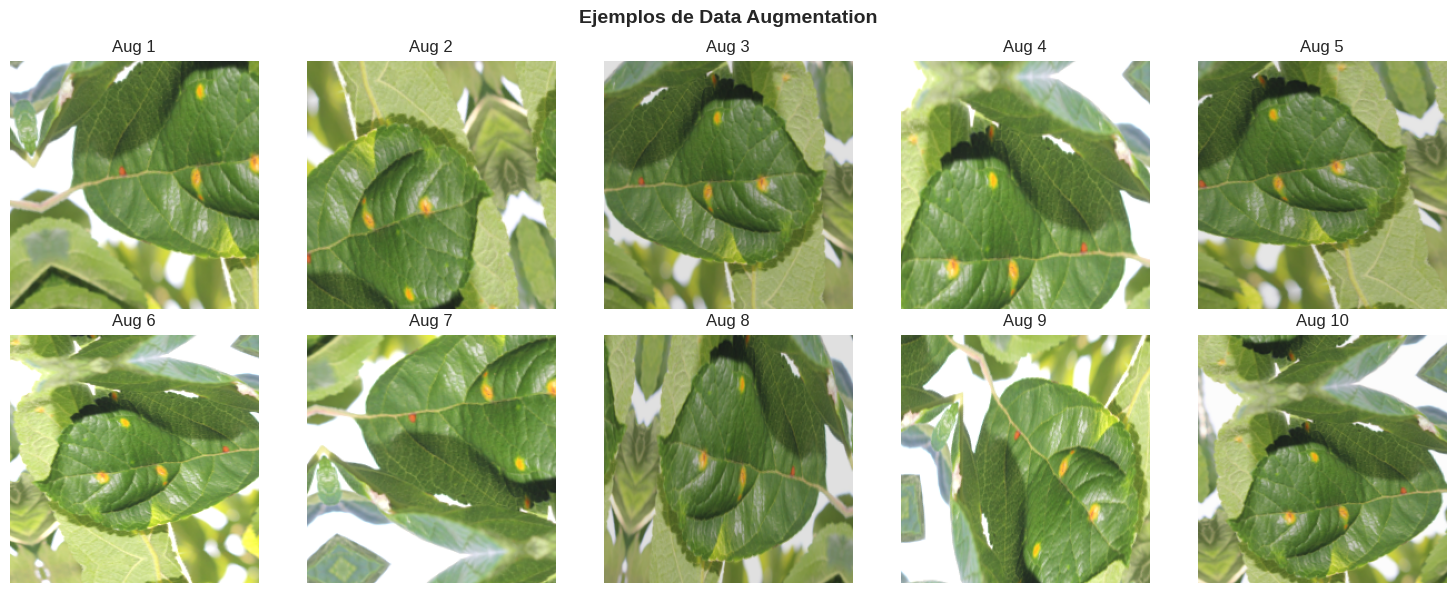

In [ ]:
# Visualizar ejemplos de Data Augmentation
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Cargar una imagen de ejemplo
sample_img_path = train_data.iloc[0]['image_path']
sample_img = Image.open(sample_img_path).resize((IMG_SIZE, IMG_SIZE))
sample_array = np.array(sample_img).reshape((1, IMG_SIZE, IMG_SIZE, 3))

# Generar augmentations
augmented_images = [train_datagen.random_transform(sample_array[0]) for _ in range(10)]

for i, (ax, aug_img) in enumerate(zip(axes.flat, augmented_images)):
    ax.imshow(aug_img.astype('uint8') if aug_img.max() > 1 else aug_img)
    ax.axis('off')
    ax.set_title(f'Aug {i+1}')

plt.suptitle('Ejemplos de Data Augmentation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/augmentation_examples.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Construcción del Modelo

In [ ]:
def build_model(num_classes=4, img_size=224, learning_rate=1e-4):
    """
    Construir modelo EfficientNetB0 con Transfer Learning.

    Arquitectura:
    - Base: EfficientNetB0 preentrenado en ImageNet
    - Global Average Pooling
    - Dense 256 con BatchNorm y Dropout
    - Output: Softmax para 4 clases
    """
    # Cargar modelo base preentrenado
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(img_size, img_size, 3)
    )

    # Congelar capas del modelo base inicialmente
    base_model.trainable = False

    # Construir modelo completo
    inputs = keras.Input(shape=(img_size, img_size, 3), name='input_image')

    # Pasar por modelo base
    x = base_model(inputs, training=False)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)

    # Capa densa con regularización
    x = layers.Dense(256, name='dense_256')(x)
    x = layers.BatchNormalization(name='batch_norm')(x)
    x = layers.Activation('relu', name='relu_activation')(x)
    x = layers.Dropout(0.5, name='dropout')(x)

    # Capa de salida
    outputs = layers.Dense(
        num_classes,
        activation='softmax',
        name='predictions'
    )(x)

    # Crear modelo
    model = Model(inputs, outputs, name='PlantDiseaseClassifier')

    # Compilar
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )

    return model, base_model

# Construir modelo
model, base_model = build_model(
    num_classes=len(CLASS_NAMES),
    img_size=IMG_SIZE,
    learning_rate=LEARNING_RATE
)

print("✅ Modelo construido:")
model.summary()

✅ Modelo construido:


Model: "PlantDiseaseClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm (BatchNormalization) │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_activation (Activation)    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,559 (16.71 MB)

 Trainable params: 329,476 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

In [ ]:
# Visualizar arquitectura
keras.utils.plot_model(
    model,
    to_file='/content/model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=150
)

print(f"📊 Parámetros del modelo:")
print(f"   Total: {model.count_params():,}")
print(f"   Entrenables: {sum(p.numpy().size for p in model.trainable_weights):,}")
print(f"   No entrenables: {sum(p.numpy().size for p in model.non_trainable_weights):,}")

📊 Parámetros del modelo:
   Total: 4,379,559
   Entrenables: 329,476
   No entrenables: 4,050,083


## 6. Entrenamiento del Modelo

In [ ]:
# Configurar callbacks
CHECKPOINT_PATH = '/content/best_model.keras'
LOG_DIR = f'/content/logs/{datetime.now().strftime("%Y%m%d-%H%M%S")}'

callbacks = [
    # Guardar mejor modelo
    ModelCheckpoint(
        filepath=CHECKPOINT_PATH,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),

    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # Reducir learning rate cuando se estanca
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    # TensorBoard
    TensorBoard(
        log_dir=LOG_DIR,
        histogram_freq=1
    )
]

print("✅ Callbacks configurados:")
print("   - ModelCheckpoint: Guarda el mejor modelo")
print("   - EarlyStopping: Detiene si no mejora en 10 épocas")
print("   - ReduceLROnPlateau: Reduce LR si se estanca")
print("   - TensorBoard: Logs para visualización")

✅ Callbacks configurados:
   - ModelCheckpoint: Guarda el mejor modelo
   - EarlyStopping: Detiene si no mejora en 10 épocas
   - ReduceLROnPlateau: Reduce LR si se estanca
   - TensorBoard: Logs para visualización


In [ ]:
# FASE 1: Entrenar solo las capas superiores (feature extraction)
print("="*60)
print("FASE 1: Feature Extraction (capas base congeladas)")
print("="*60)

history_phase1 = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Fase 1 completada")

FASE 1: Feature Extraction (capas base congeladas)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3098 - auc: 0.5947 - loss: 1.7020
Epoch 1: val_accuracy improved from -inf to 0.35890, saving model to /content/best_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.3111 - auc: 0.5958 - loss: 1.7009 - val_accuracy: 0.3589 - val_auc: 0.6462 - val_loss: 1.3068 - learning_rate: 1.0000e-04
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.4811 - auc: 0.7431 - loss: 1.4647
Epoch 2: val_accuracy improved from 0.35890 to 0.53973, saving model to /content/best_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 954ms/step - accuracy: 0.4817 - auc: 0.7435 - loss: 1.4627 - val_accuracy: 0.5397 - val_auc: 0.7995 - val_loss: 1.1397 - learning_rate: 1.0000e-04
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.5515 - auc: 0.7947 - loss: 1.2974
Epoch 3: val_accuracy improved from 0.53973 to 0.63562, saving model to /content/best_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 938ms/step - accuracy: 0.55

In [ ]:
# FASE 2: Fine-tuning - descongelar últimas capas del modelo base
print("="*60)
print("FASE 2: Fine-Tuning (últimas capas descongeladas)")
print("="*60)

# Descongelar las últimas 30 capas del modelo base
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompilar con learning rate más bajo
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE / 10),  # LR más bajo para fine-tuning
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

print(f"Capas entrenables ahora: {len([l for l in model.layers if l.trainable])}")

# Continuar entrenamiento
history_phase2 = model.fit(
    train_generator,
    epochs=EPOCHS,
    initial_epoch=len(history_phase1.history['loss']),
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Fase 2 completada")

FASE 2: Fine-Tuning (últimas capas descongeladas)
Capas entrenables ahora: 8
Epoch 16/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5254 - auc: 0.7753 - loss: 1.2111
Epoch 16: val_accuracy improved from 0.82192 to 0.83836, saving model to /content/best_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.5254 - auc: 0.7751 - loss: 1.2127 - val_accuracy: 0.8384 - val_auc: 0.9593 - val_loss: 0.7457 - learning_rate: 1.0000e-05
Epoch 17/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.5482 - auc: 0.7882 - loss: 1.2929
Epoch 17: val_accuracy did not improve from 0.83836
46/46 ━━━━━━━━━━━━━━━━━━━━ 42s 906ms/step - accuracy: 0.5483 - auc: 0.7882 - loss: 1.2927 - val_accuracy: 0.8301 - val_auc: 0.9581 - val_loss: 0.7496 - learning_rate: 1.0000e-05
Epoch 18/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.5755 - auc: 0.8082 - loss: 1.2749
Epoch 18: val_accuracy did not improve from 0.83836
46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 932ms/step - accuracy: 0.5752 - auc

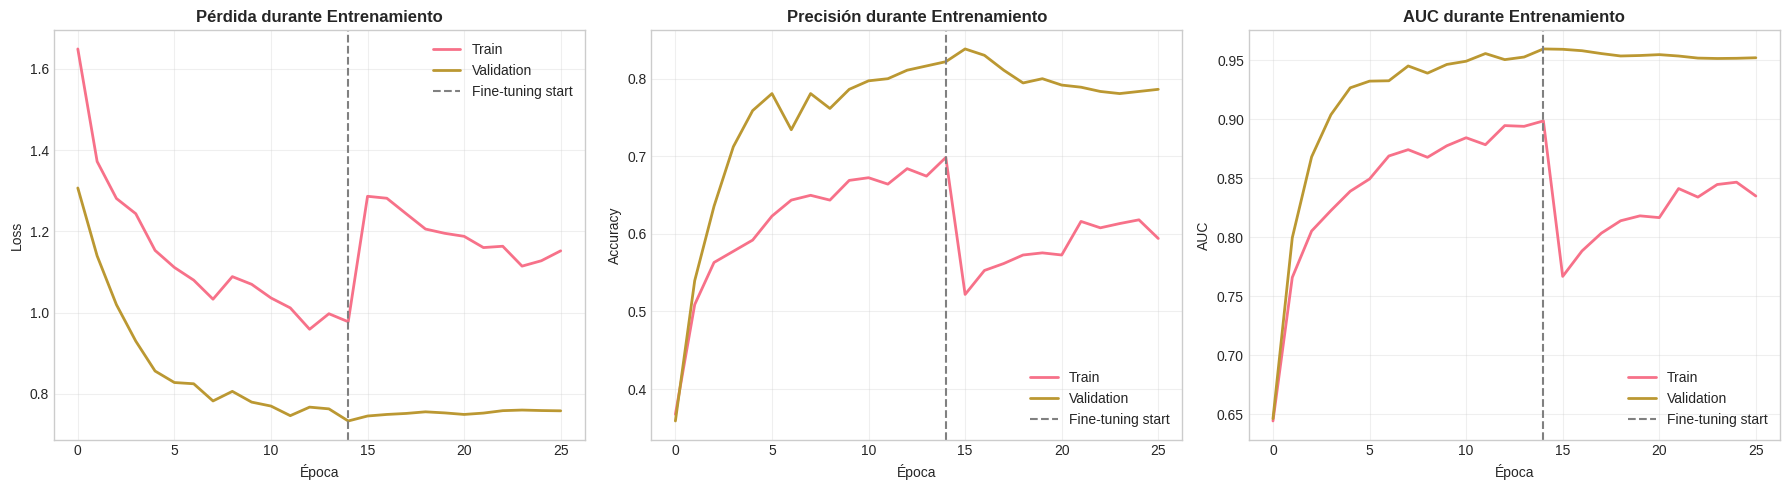


📊 Métricas Finales:
   Train Accuracy: 0.5941
   Val Accuracy: 0.7863
   Val AUC: 0.9521


In [ ]:
# Combinar historiales de entrenamiento
def combine_histories(h1, h2):
    combined = {}
    for key in h1.history.keys():
        combined[key] = h1.history[key] + h2.history[key]
    return combined

full_history = combine_histories(history_phase1, history_phase2)

# Visualizar curvas de entrenamiento
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
ax1 = axes[0]
ax1.plot(full_history['loss'], label='Train', linewidth=2)
ax1.plot(full_history['val_loss'], label='Validation', linewidth=2)
ax1.axvline(x=len(history_phase1.history['loss'])-1, color='gray', linestyle='--', label='Fine-tuning start')
ax1.set_xlabel('Época')
ax1.set_ylabel('Loss')
ax1.set_title('Pérdida durante Entrenamiento', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2 = axes[1]
ax2.plot(full_history['accuracy'], label='Train', linewidth=2)
ax2.plot(full_history['val_accuracy'], label='Validation', linewidth=2)
ax2.axvline(x=len(history_phase1.history['loss'])-1, color='gray', linestyle='--', label='Fine-tuning start')
ax2.set_xlabel('Época')
ax2.set_ylabel('Accuracy')
ax2.set_title('Precisión durante Entrenamiento', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# AUC
ax3 = axes[2]
ax3.plot(full_history['auc'], label='Train', linewidth=2)
ax3.plot(full_history['val_auc'], label='Validation', linewidth=2)
ax3.axvline(x=len(history_phase1.history['loss'])-1, color='gray', linestyle='--', label='Fine-tuning start')
ax3.set_xlabel('Época')
ax3.set_ylabel('AUC')
ax3.set_title('AUC durante Entrenamiento', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Métricas finales
print("\n📊 Métricas Finales:")
print(f"   Train Accuracy: {full_history['accuracy'][-1]:.4f}")
print(f"   Val Accuracy: {full_history['val_accuracy'][-1]:.4f}")
print(f"   Val AUC: {full_history['val_auc'][-1]:.4f}")

## 7. Evaluación del Modelo

In [ ]:
# Cargar el mejor modelo guardado
best_model = keras.models.load_model(CHECKPOINT_PATH)
print("✅ Mejor modelo cargado desde checkpoint")

# Evaluar en conjunto de validación
val_generator.reset()
val_loss, val_acc, val_auc = best_model.evaluate(val_generator, verbose=1)

print(f"\n📊 Evaluación en Validación:")
print(f"   Loss: {val_loss:.4f}")
print(f"   Accuracy: {val_acc:.4f}")
print(f"   AUC: {val_auc:.4f}")

✅ Mejor modelo cargado desde checkpoint
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 749ms/step - accuracy: 0.8331 - auc: 0.9552 - loss: 0.7624

📊 Evaluación en Validación:
   Loss: 0.7457
   Accuracy: 0.8384
   AUC: 0.9593


In [ ]:
# Obtener predicciones
val_generator.reset()
y_pred_probs = best_model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas reales
y_true = np.array([np.argmax(val_data[CLASS_NAMES].iloc[i].values)
                   for i in range(len(val_data))])

print(f"Predicciones: {y_pred.shape}")
print(f"Etiquetas reales: {y_true.shape}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 929ms/step
Predicciones: (365,)
Etiquetas reales: (365,)


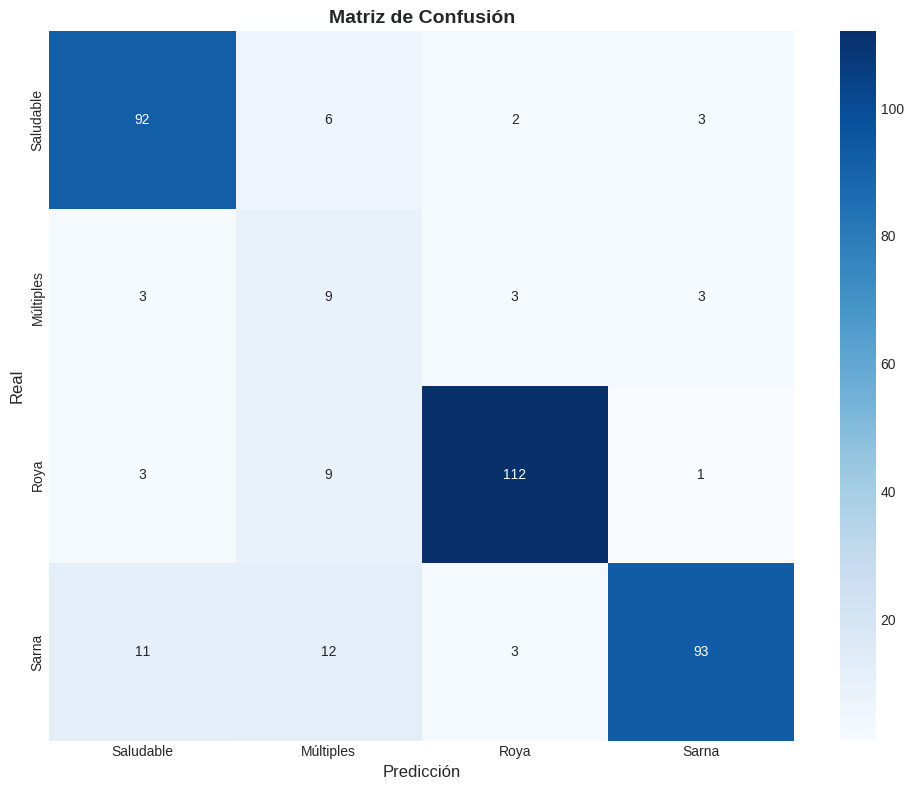

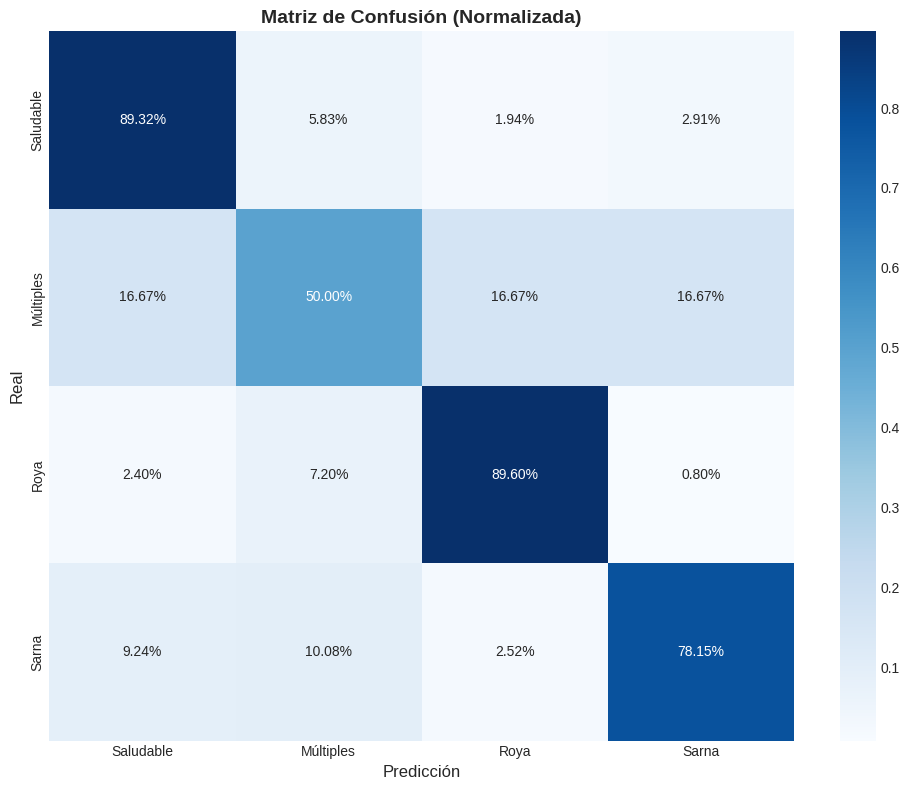

In [ ]:
# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CLASS_LABELS_ES,
    yticklabels=CLASS_LABELS_ES,
    ax=ax
)
ax.set_xlabel('Predicción', fontsize=12)
ax.set_ylabel('Real', fontsize=12)
ax.set_title('Matriz de Confusión', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Matriz normalizada
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2%',
    cmap='Blues',
    xticklabels=CLASS_LABELS_ES,
    yticklabels=CLASS_LABELS_ES,
    ax=ax
)
ax.set_xlabel('Predicción', fontsize=12)
ax.set_ylabel('Real', fontsize=12)
ax.set_title('Matriz de Confusión (Normalizada)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/confusion_matrix_normalized.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Reporte de Clasificación
print("📋 Reporte de Clasificación:")
print("="*60)
print(classification_report(
    y_true,
    y_pred,
    target_names=CLASS_LABELS_ES,
    digits=4
))

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

   Saludable     0.8440    0.8932    0.8679       103
   Múltiples     0.2500    0.5000    0.3333        18
        Roya     0.9333    0.8960    0.9143       125
       Sarna     0.9300    0.7815    0.8493       119

    accuracy                         0.8384       365
   macro avg     0.7393    0.7677    0.7412       365
weighted avg     0.8733    0.8384    0.8514       365



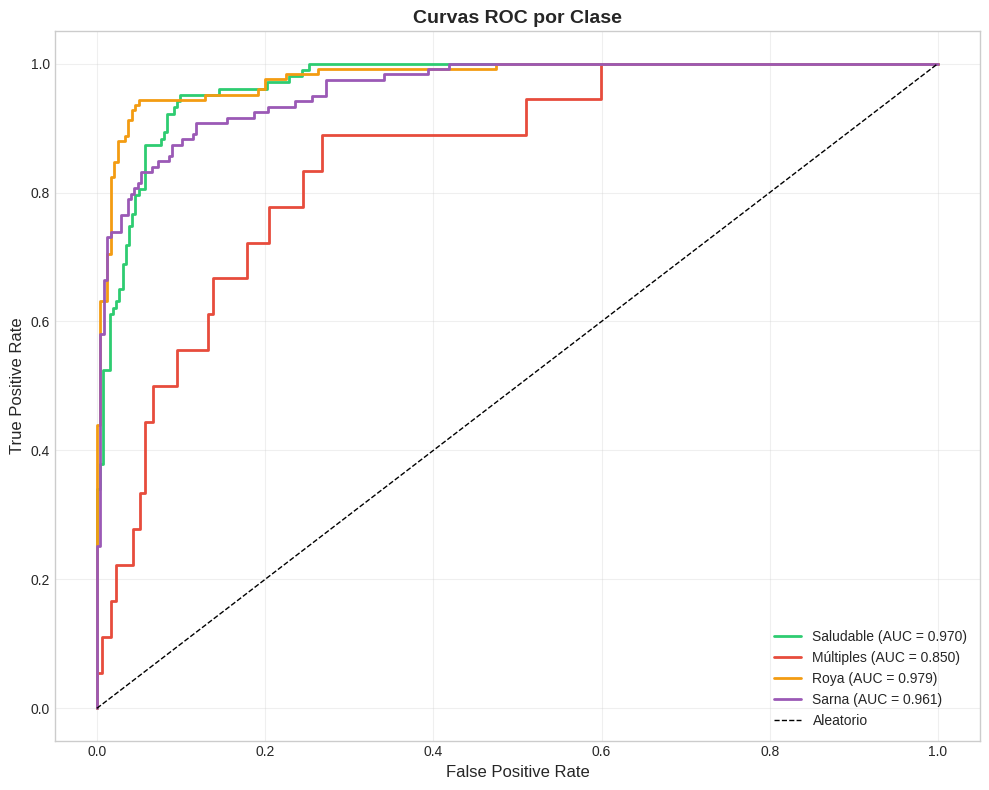


📊 AUC Macro (promedio): 0.9399


In [ ]:
# Curvas ROC por clase
fig, ax = plt.subplots(figsize=(10, 8))

# One-hot encode y_true para ROC
y_true_onehot = np.zeros((len(y_true), len(CLASS_NAMES)))
for i, label in enumerate(y_true):
    y_true_onehot[i, label] = 1

# Calcular ROC para cada clase
for i, (cls, color, label) in enumerate(zip(CLASS_NAMES, CLASS_COLORS, CLASS_LABELS_ES)):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    auc_score = roc_auc_score(y_true_onehot[:, i], y_pred_probs[:, i])
    ax.plot(fpr, tpr, color=color, linewidth=2, label=f'{label} (AUC = {auc_score:.3f})')

# Línea diagonal (clasificador aleatorio)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Aleatorio')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Curvas ROC por Clase', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# AUC promedio
macro_auc = roc_auc_score(y_true_onehot, y_pred_probs, average='macro')
print(f"\n📊 AUC Macro (promedio): {macro_auc:.4f}")

/tmp/ipython-input-3781498791.py:40: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3781498791.py:40: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3781498791.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  plt.savefig('/content/prediction_examples.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-3781498791.py:41: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Liberation Sans.
  plt.savefig('/content/prediction_examples.png', dpi=150, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CR

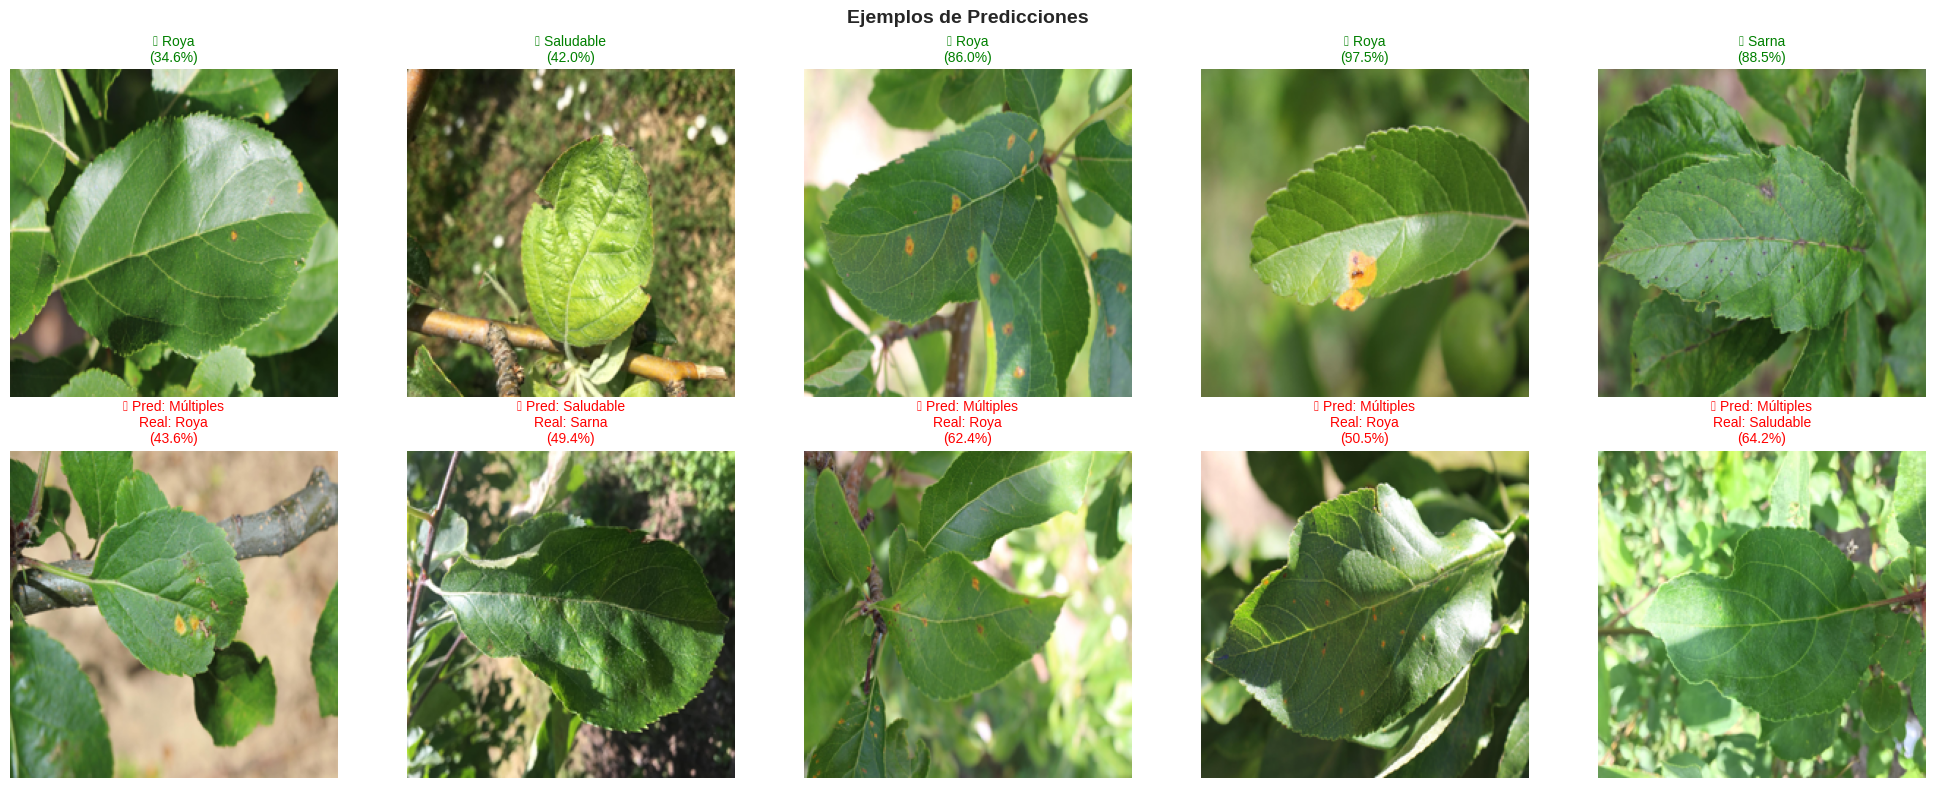

In [ ]:
# Visualizar predicciones correctas e incorrectas
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Predicciones correctas
correct_indices = np.where(y_pred == y_true)[0][:5]
for i, idx in enumerate(correct_indices):
    img_path = val_data.iloc[idx]['image_path']
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))

    ax = axes[0, i]
    ax.imshow(img)
    ax.axis('off')
    true_label = CLASS_LABELS_ES[y_true[idx]]
    pred_label = CLASS_LABELS_ES[y_pred[idx]]
    conf = y_pred_probs[idx][y_pred[idx]] * 100
    ax.set_title(f'✅ {pred_label}\n({conf:.1f}%)', fontsize=10, color='green')

axes[0, 0].set_ylabel('CORRECTAS', fontsize=12, fontweight='bold')

# Predicciones incorrectas
incorrect_indices = np.where(y_pred != y_true)[0][:5]
for i, idx in enumerate(incorrect_indices):
    if idx >= len(val_data):
        continue
    img_path = val_data.iloc[idx]['image_path']
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))

    ax = axes[1, i]
    ax.imshow(img)
    ax.axis('off')
    true_label = CLASS_LABELS_ES[y_true[idx]]
    pred_label = CLASS_LABELS_ES[y_pred[idx]]
    conf = y_pred_probs[idx][y_pred[idx]] * 100
    ax.set_title(f'❌ Pred: {pred_label}\nReal: {true_label}\n({conf:.1f}%)',
                 fontsize=10, color='red')

axes[1, 0].set_ylabel('INCORRECTAS', fontsize=12, fontweight='bold')

plt.suptitle('Ejemplos de Predicciones', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/prediction_examples.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Análisis de Overfitting/Underfitting

In [ ]:
# Análisis de Overfitting/Underfitting
train_acc_final = full_history['accuracy'][-1]
val_acc_final = full_history['val_accuracy'][-1]
gap = train_acc_final - val_acc_final

print("📊 Análisis de Overfitting/Underfitting:")
print("="*60)
print(f"   Accuracy de Entrenamiento: {train_acc_final:.4f}")
print(f"   Accuracy de Validación: {val_acc_final:.4f}")
print(f"   Gap (diferencia): {gap:.4f}")
print()

if val_acc_final < 0.70:
    print("⚠️ UNDERFITTING: El modelo no está aprendiendo lo suficiente.")
    print("   Sugerencias:")
    print("   - Aumentar la complejidad del modelo")
    print("   - Entrenar más épocas")
    print("   - Reducir regularización (dropout)")
elif gap > 0.15:
    print("⚠️ OVERFITTING: El modelo memoriza pero no generaliza.")
    print("   Sugerencias:")
    print("   - Aumentar Data Augmentation")
    print("   - Aumentar Dropout")
    print("   - Early Stopping más agresivo")
    print("   - Más datos de entrenamiento")
else:
    print("✅ BALANCED: El modelo tiene buen equilibrio entre train y val.")
    print("   El gap es razonable y el modelo generaliza bien.")

📊 Análisis de Overfitting/Underfitting:
   Accuracy de Entrenamiento: 0.5941
   Accuracy de Validación: 0.7863
   Gap (diferencia): -0.1922

✅ BALANCED: El modelo tiene buen equilibrio entre train y val.
   El gap es razonable y el modelo generaliza bien.


In [ ]:
# Análisis por clase (especialmente multiple_diseases)
print("\n📊 Análisis de Rendimiento por Clase:")
print("="*60)

for i, (cls, label) in enumerate(zip(CLASS_NAMES, CLASS_LABELS_ES)):
    # Calcular métricas para esta clase
    class_mask = y_true == i
    if class_mask.sum() == 0:
        continue

    class_correct = (y_pred[class_mask] == y_true[class_mask]).sum()
    class_total = class_mask.sum()
    class_acc = class_correct / class_total

    print(f"\n{label}:")
    print(f"   Muestras en validación: {class_total}")
    print(f"   Correctas: {class_correct}")
    print(f"   Accuracy: {class_acc:.2%}")

    # Análisis de errores
    errors = y_pred[class_mask & (y_pred != y_true)]
    if len(errors) > 0:
        print(f"   Errores más comunes:")
        for err_class, count in zip(*np.unique(errors, return_counts=True)):
            print(f"      → Confundida con {CLASS_LABELS_ES[err_class]}: {count} veces")


📊 Análisis de Rendimiento por Clase:

Saludable:
   Muestras en validación: 103
   Correctas: 92
   Accuracy: 89.32%
   Errores más comunes:
      → Confundida con Múltiples: 6 veces
      → Confundida con Roya: 2 veces
      → Confundida con Sarna: 3 veces

Múltiples:
   Muestras en validación: 18
   Correctas: 9
   Accuracy: 50.00%
   Errores más comunes:
      → Confundida con Saludable: 3 veces
      → Confundida con Roya: 3 veces
      → Confundida con Sarna: 3 veces

Roya:
   Muestras en validación: 125
   Correctas: 112
   Accuracy: 89.60%
   Errores más comunes:
      → Confundida con Saludable: 3 veces
      → Confundida con Múltiples: 9 veces
      → Confundida con Sarna: 1 veces

Sarna:
   Muestras en validación: 119
   Correctas: 93
   Accuracy: 78.15%
   Errores más comunes:
      → Confundida con Saludable: 11 veces
      → Confundida con Múltiples: 12 veces
      → Confundida con Roya: 3 veces


## 9. Guardar Modelo en Formato Keras

In [ ]:
# Guardar modelo final en formato Keras
KERAS_MODEL_PATH = '/content/plant_disease_model.keras'
best_model.save(KERAS_MODEL_PATH)
print(f"✅ Modelo guardado en: {KERAS_MODEL_PATH}")

# También guardar en formato SavedModel (necesario para conversión a TF.js)
SAVED_MODEL_PATH = '/content/plant_disease_savedmodel'
best_model.export(SAVED_MODEL_PATH)
print(f"✅ SavedModel guardado en: {SAVED_MODEL_PATH}")

# Verificar tamaño
import shutil
keras_size = os.path.getsize(KERAS_MODEL_PATH) / (1024 * 1024)
savedmodel_size = sum(
    os.path.getsize(os.path.join(dirpath, filename))
    for dirpath, dirnames, filenames in os.walk(SAVED_MODEL_PATH)
    for filename in filenames
) / (1024 * 1024)

print(f"\n📦 Tamaño del modelo:")
print(f"   Keras: {keras_size:.2f} MB")
print(f"   SavedModel: {savedmodel_size:.2f} MB")

✅ Modelo guardado en: /content/plant_disease_model.keras
Saved artifact at '/content/plant_disease_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_image')]
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140303708111120: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140303708110928: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140303699516048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303699525456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303411668624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303699515856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303699517200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303411665936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303411668816: TensorSpec(shape=(), dtype=tf.resource, 

## 10. Conversión a TensorFlow.js (GraphModel)

In [ ]:
# Convertir a TensorFlow.js GraphModel
import tensorflowjs as tfjs

TFJS_MODEL_PATH = '/content/tfjs_model'

print("🔄 Convirtiendo modelo a TensorFlow.js...")
print("   Formato: GraphModel (optimizado para producción)")
print("   Sin cuantización (máxima precisión)")

# Usar el conversor de línea de comandos para mayor control
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --signature_name=serving_default \
    --saved_model_tags=serve \
    {SAVED_MODEL_PATH} \
    {TFJS_MODEL_PATH}

print(f"\n✅ Modelo convertido a TensorFlow.js en: {TFJS_MODEL_PATH}")

🔄 Convirtiendo modelo a TensorFlow.js...
   Formato: GraphModel (optimizado para producción)
   Sin cuantización (máxima precisión)
2026-01-13 16:52:19.663099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768323139.697638   13000 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768323139.707247   13000 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768323139.732062   13000 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768323139.732092   13000 computation_placer.cc:177] computation placer already registered. Please check linkage and a

In [ ]:
# Verificar archivos generados
print("📂 Archivos generados:")
!ls -la {TFJS_MODEL_PATH}

# Calcular tamaño total
tfjs_size = sum(
    os.path.getsize(os.path.join(TFJS_MODEL_PATH, f))
    for f in os.listdir(TFJS_MODEL_PATH)
) / (1024 * 1024)

print(f"\n📦 Tamaño total TensorFlow.js: {tfjs_size:.2f} MB")

📂 Archivos generados:
total 17212
drwxr-xr-x 2 root root    4096 Jan 13 16:52 .
drwxr-xr-x 1 root root    4096 Jan 13 16:52 ..
-rw-r--r-- 1 root root 4194304 Jan 13 16:52 group1-shard1of5.bin
-rw-r--r-- 1 root root 4194304 Jan 13 16:52 group1-shard2of5.bin
-rw-r--r-- 1 root root 4194304 Jan 13 16:52 group1-shard3of5.bin
-rw-r--r-- 1 root root 4194304 Jan 13 16:52 group1-shard4of5.bin
-rw-r--r-- 1 root root  523400 Jan 13 16:52 group1-shard5of5.bin
-rw-r--r-- 1 root root  315107 Jan 13 16:52 model.json

📦 Tamaño total TensorFlow.js: 16.80 MB


In [ ]:
# Verificar el model.json
with open(os.path.join(TFJS_MODEL_PATH, 'model.json'), 'r') as f:
    model_json = json.load(f)

print("📋 Información del modelo TensorFlow.js:")
print(f"   Formato: {model_json.get('format', 'N/A')}")
print(f"   Generado por: {model_json.get('generatedBy', 'N/A')}")
print(f"   Convertido por: {model_json.get('convertedBy', 'N/A')}")

if 'weightsManifest' in model_json:
    weights = model_json['weightsManifest']
    print(f"   Archivos de pesos: {len(weights[0]['paths'])}")
    for path in weights[0]['paths']:
        print(f"      - {path}")

📋 Información del modelo TensorFlow.js:
   Formato: graph-model
   Generado por: 2.19.0
   Convertido por: TensorFlow.js Converter v4.17.0
   Archivos de pesos: 5
      - group1-shard1of5.bin
      - group1-shard2of5.bin
      - group1-shard3of5.bin
      - group1-shard4of5.bin
      - group1-shard5of5.bin


## 11. Crear Archivo de Metadatos

In [ ]:
# Crear archivo de metadatos para usar con el modelo
metadata = {
    "model_name": "PlantDiseaseClassifier",
    "version": "1.0.0",
    "created_at": datetime.now().isoformat(),
    "framework": "TensorFlow.js",
    "model_type": "GraphModel",
    "architecture": "EfficientNetB0",
    "input": {
        "shape": [1, IMG_SIZE, IMG_SIZE, 3],
        "dtype": "float32",
        "preprocessing": {
            "resize": [IMG_SIZE, IMG_SIZE],
            "normalize": "divide_by_255",
            "note": "Normalizar píxeles a rango [0, 1]"
        }
    },
    "output": {
        "shape": [1, 4],
        "dtype": "float32",
        "activation": "softmax",
        "classes": CLASS_NAMES,
        "class_labels": {
            "healthy": {"index": 0, "label_es": "Saludable", "color": "#2ecc71"},
            "multiple_diseases": {"index": 1, "label_es": "Múltiples Enfermedades", "color": "#e74c3c"},
            "rust": {"index": 2, "label_es": "Roya", "color": "#f39c12"},
            "scab": {"index": 3, "label_es": "Sarna", "color": "#9b59b6"}
        }
    },
    "training": {
        "dataset": "Plant Pathology 2020 - FGVC7",
        "total_samples": len(train_df),
        "train_samples": len(train_data),
        "val_samples": len(val_data),
        "class_distribution": {k: int(v) for k, v in class_distribution.items()}, # Convert np.int64 to int
        "epochs_trained": len(full_history['loss']),
        "batch_size": BATCH_SIZE,
        "optimizer": "Adam",
        "loss": "CategoricalCrossentropy with label_smoothing=0.1",
        "class_weights_used": True
    },
    "performance": {
        "val_accuracy": float(val_acc),
        "val_loss": float(val_loss),
        "val_auc": float(val_auc),
        "macro_auc": float(macro_auc)
    }
}

# Guardar metadatos
metadata_path = os.path.join(TFJS_MODEL_PATH, 'metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ Metadatos guardados en:", metadata_path)
print("\n📋 Contenido:")
print(json.dumps(metadata, indent=2))

✅ Metadatos guardados en: /content/tfjs_model/metadata.json

📋 Contenido:
{
  "model_name": "PlantDiseaseClassifier",
  "version": "1.0.0",
  "created_at": "2026-01-13T16:55:10.989605",
  "framework": "TensorFlow.js",
  "model_type": "GraphModel",
  "architecture": "EfficientNetB0",
  "input": {
    "shape": [
      1,
      224,
      224,
      3
    ],
    "dtype": "float32",
    "preprocessing": {
      "resize": [
        224,
        224
      ],
      "normalize": "divide_by_255",
      "note": "Normalizar p\u00edxeles a rango [0, 1]"
    }
  },
  "output": {
    "shape": [
      1,
      4
    ],
    "dtype": "float32",
    "activation": "softmax",
    "classes": [
      "healthy",
      "multiple_diseases",
      "rust",
      "scab"
    ],
    "class_labels": {
      "healthy": {
        "index": 0,
        "label_es": "Saludable",
        "color": "#2ecc71"
      },
      "multiple_diseases": {
        "index": 1,
        "label_es": "M\u00faltiples Enfermedades",
        "c

## 12. Test de Inferencia con TensorFlow.js (Node.js)

🧪 Test de inferencia con modelo Keras...

Imagen: /content/plant-pathology-2020/images/Train_735.jpg
Probabilidades:
   Saludable: 19.43%
   Múltiples: 8.08%
   Roya: 31.70%
   Sarna: 40.79%

🎯 Predicción: Sarna


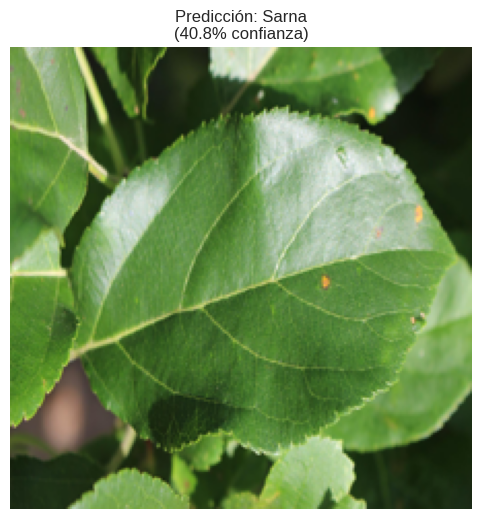

In [ ]:
# Test rápido de inferencia con el modelo Keras para verificar que funciona
print("🧪 Test de inferencia con modelo Keras...")

# Cargar una imagen de test
test_img_path = val_data.iloc[0]['image_path']
test_img = Image.open(test_img_path).resize((IMG_SIZE, IMG_SIZE))
test_array = np.array(test_img) / 255.0
test_array = np.expand_dims(test_array, axis=0)

# Predecir
prediction = best_model.predict(test_array, verbose=0)

print(f"\nImagen: {test_img_path}")
print(f"Probabilidades:")
for cls, label, prob in zip(CLASS_NAMES, CLASS_LABELS_ES, prediction[0]):
    print(f"   {label}: {prob*100:.2f}%")

predicted_class = CLASS_LABELS_ES[np.argmax(prediction)]
print(f"\n🎯 Predicción: {predicted_class}")

# Mostrar imagen
plt.figure(figsize=(6, 6))
plt.imshow(test_img)
plt.title(f"Predicción: {predicted_class}\n({prediction[0][np.argmax(prediction)]*100:.1f}% confianza)")
plt.axis('off')
plt.show()

## 13. Empaquetar y Descargar

In [ ]:
# Crear archivo ZIP con todo lo necesario
import zipfile

ZIP_PATH = '/content/plant_disease_model_tfjs.zip'

with zipfile.ZipFile(ZIP_PATH, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Añadir archivos del modelo TensorFlow.js
    for filename in os.listdir(TFJS_MODEL_PATH):
        file_path = os.path.join(TFJS_MODEL_PATH, filename)
        arcname = os.path.join('tfjs_model', filename)
        zipf.write(file_path, arcname)
        print(f"   Añadido: {arcname}")

zip_size = os.path.getsize(ZIP_PATH) / (1024 * 1024)
print(f"\n✅ ZIP creado: {ZIP_PATH}")
print(f"   Tamaño: {zip_size:.2f} MB")

   Añadido: tfjs_model/group1-shard1of5.bin
   Añadido: tfjs_model/model.json
   Añadido: tfjs_model/group1-shard4of5.bin
   Añadido: tfjs_model/group1-shard2of5.bin
   Añadido: tfjs_model/group1-shard3of5.bin
   Añadido: tfjs_model/group1-shard5of5.bin
   Añadido: tfjs_model/metadata.json

✅ ZIP creado: /content/plant_disease_model_tfjs.zip
   Tamaño: 15.34 MB


In [ ]:
# También crear ZIP con el modelo Keras (por si se necesita)
ZIP_KERAS_PATH = '/content/plant_disease_model_keras.zip'

with zipfile.ZipFile(ZIP_KERAS_PATH, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(KERAS_MODEL_PATH, 'plant_disease_model.keras')

keras_zip_size = os.path.getsize(ZIP_KERAS_PATH) / (1024 * 1024)
print(f"✅ ZIP Keras creado: {ZIP_KERAS_PATH}")
print(f"   Tamaño: {keras_zip_size:.2f} MB")

✅ ZIP Keras creado: /content/plant_disease_model_keras.zip
   Tamaño: 28.27 MB


In [ ]:
# Crear ZIP con visualizaciones y reportes
ZIP_REPORTS_PATH = '/content/plant_disease_reports.zip'

report_files = [
    '/content/class_distribution.png',
    '/content/sample_images.png',
    '/content/augmentation_examples.png',
    '/content/training_curves.png',
    '/content/confusion_matrix.png',
    '/content/confusion_matrix_normalized.png',
    '/content/roc_curves.png',
    '/content/prediction_examples.png'
]

with zipfile.ZipFile(ZIP_REPORTS_PATH, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file_path in report_files:
        if os.path.exists(file_path):
            zipf.write(file_path, os.path.basename(file_path))
            print(f"   Añadido: {os.path.basename(file_path)}")

reports_zip_size = os.path.getsize(ZIP_REPORTS_PATH) / (1024 * 1024)
print(f"\n✅ ZIP Reports creado: {ZIP_REPORTS_PATH}")
print(f"   Tamaño: {reports_zip_size:.2f} MB")

   Añadido: class_distribution.png
   Añadido: sample_images.png
   Añadido: augmentation_examples.png
   Añadido: training_curves.png
   Añadido: confusion_matrix.png
   Añadido: confusion_matrix_normalized.png
   Añadido: roc_curves.png
   Añadido: prediction_examples.png

✅ ZIP Reports creado: /content/plant_disease_reports.zip
   Tamaño: 10.94 MB


In [ ]:
# Descargar archivos
from google.colab import files

print("📥 Archivos disponibles para descargar:")
print(f"   1. Modelo TensorFlow.js: plant_disease_model_tfjs.zip ({zip_size:.2f} MB)")
print(f"   2. Modelo Keras: plant_disease_model_keras.zip ({keras_zip_size:.2f} MB)")
print(f"   3. Reportes y gráficos: plant_disease_reports.zip ({reports_zip_size:.2f} MB)")
print("\n⬇️ Descargando...")

files.download(ZIP_PATH)
files.download(ZIP_KERAS_PATH)
files.download(ZIP_REPORTS_PATH)

📥 Archivos disponibles para descargar:
   1. Modelo TensorFlow.js: plant_disease_model_tfjs.zip (15.34 MB)
   2. Modelo Keras: plant_disease_model_keras.zip (28.27 MB)
   3. Reportes y gráficos: plant_disease_reports.zip (10.94 MB)

⬇️ Descargando...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 14. Código de Ejemplo para Server-Side Inference

In [ ]:
# Generar código de ejemplo para usar en Node.js
nodejs_code = '''
// server-inference.js
// Ejemplo de inferencia server-side con TensorFlow.js en Node.js

const tf = require('@tensorflow/tfjs-node');
const fs = require('fs');
const path = require('path');
const jpeg = require('jpeg-js');  // npm install jpeg-js

// Configuración
const MODEL_PATH = './tfjs_model/model.json';
const IMG_SIZE = 224;
const CLASS_NAMES = ['healthy', 'multiple_diseases', 'rust', 'scab'];
const CLASS_LABELS = ['Saludable', 'Múltiples Enfermedades', 'Roya', 'Sarna'];

let model = null;

// Cargar modelo
async function loadModel() {
    if (!model) {
        console.log('Cargando modelo...');
        model = await tf.loadGraphModel(`file://${MODEL_PATH}`);
        console.log('Modelo cargado correctamente');

        // Warmup
        const warmupTensor = tf.zeros([1, IMG_SIZE, IMG_SIZE, 3]);
        await model.predict(warmupTensor);
        warmupTensor.dispose();
        console.log('Warmup completado');
    }
    return model;
}

// Preprocesar imagen
function preprocessImage(imageBuffer) {
    // Decodificar JPEG
    const rawImageData = jpeg.decode(imageBuffer, { useTArray: true });

    // Crear tensor y redimensionar
    const imageTensor = tf.browser.fromPixels({
        data: rawImageData.data,
        width: rawImageData.width,
        height: rawImageData.height
    });

    // Redimensionar, normalizar y añadir dimensión de batch
    const resized = tf.image.resizeBilinear(imageTensor, [IMG_SIZE, IMG_SIZE]);
    const normalized = resized.div(255.0);
    const batched = normalized.expandDims(0);

    // Limpiar tensores intermedios
    imageTensor.dispose();
    resized.dispose();
    normalized.dispose();

    return batched;
}

// Realizar predicción
async function predict(imageBuffer) {
    const model = await loadModel();

    // Preprocesar
    const inputTensor = preprocessImage(imageBuffer);

    // Predecir
    const predictions = await model.predict(inputTensor);
    const probabilities = await predictions.data();

    // Limpiar tensores
    inputTensor.dispose();
    predictions.dispose();

    // Formatear resultado
    const maxIndex = probabilities.indexOf(Math.max(...probabilities));

    return {
        prediction: CLASS_NAMES[maxIndex],
        label: CLASS_LABELS[maxIndex],
        confidence: probabilities[maxIndex],
        probabilities: CLASS_NAMES.reduce((acc, cls, i) => {
            acc[cls] = probabilities[i];
            return acc;
        }, {})
    };
}

// API endpoint ejemplo (Express.js)
/*
const express = require('express');
const multer = require('multer');
const app = express();
const upload = multer();

app.post('/api/analyze', upload.single('image'), async (req, res) => {
    try {
        const result = await predict(req.file.buffer);
        res.json(result);
    } catch (error) {
        res.status(500).json({ error: error.message });
    }
});

app.listen(3000, () => console.log('Server running on port 3000'));
*/

// Ejemplo de uso
async function main() {
    const imagePath = process.argv[2] || 'test_image.jpg';
    const imageBuffer = fs.readFileSync(imagePath);

    console.log(`Analizando: ${imagePath}`);
    const result = await predict(imageBuffer);

    console.log('\nResultado:');
    console.log(`  Predicción: ${result.label}`);
    console.log(`  Confianza: ${(result.confidence * 100).toFixed(2)}%`);
    console.log('\nProbabilidades:');
    for (const [cls, prob] of Object.entries(result.probabilities)) {
        console.log(`  ${cls}: ${(prob * 100).toFixed(2)}%`);
    }
}

main().catch(console.error);
'''

# Guardar código de ejemplo
with open('/content/server-inference.js', 'w') as f:
    f.write(nodejs_code)

print("✅ Código de ejemplo guardado en: /content/server-inference.js")
print("\n📋 Instrucciones de uso:")
print("   1. Instalar dependencias: npm install @tensorflow/tfjs-node jpeg-js")
print("   2. Copiar tfjs_model/ a tu proyecto")
print("   3. Ejecutar: node server-inference.js imagen.jpg")

✅ Código de ejemplo guardado en: /content/server-inference.js

📋 Instrucciones de uso:
   1. Instalar dependencias: npm install @tensorflow/tfjs-node jpeg-js
   2. Copiar tfjs_model/ a tu proyecto
   3. Ejecutar: node server-inference.js imagen.jpg


In [ ]:
# Generar API Route para Next.js
nextjs_api_code = '''
// app/api/analyze/route.ts
// API Route para Next.js con inferencia server-side

import { NextRequest, NextResponse } from 'next/server';
import * as tf from '@tensorflow/tfjs-node';
import path from 'path';

// Configuración
const MODEL_PATH = path.join(process.cwd(), 'public', 'models', 'tfjs_model', 'model.json');
const IMG_SIZE = 224;
const CLASS_NAMES = ['healthy', 'multiple_diseases', 'rust', 'scab'] as const;
const CLASS_LABELS: Record<typeof CLASS_NAMES[number], string> = {
    healthy: 'Saludable',
    multiple_diseases: 'Múltiples Enfermedades',
    rust: 'Roya',
    scab: 'Sarna'
};

// Cache del modelo
let model: tf.GraphModel | null = null;

async function loadModel() {
    if (!model) {
        console.log('Loading model...');
        model = await tf.loadGraphModel(`file://${MODEL_PATH}`);
        console.log('Model loaded successfully');

        // Warmup
        const warmup = tf.zeros([1, IMG_SIZE, IMG_SIZE, 3]);
        model.predict(warmup);
        warmup.dispose();
    }
    return model;
}

export async function POST(request: NextRequest) {
    try {
        const formData = await request.formData();
        const file = formData.get('image') as File;

        if (!file) {
            return NextResponse.json(
                { error: 'No image provided' },
                { status: 400 }
            );
        }

        // Cargar modelo
        const model = await loadModel();

        // Leer imagen
        const buffer = Buffer.from(await file.arrayBuffer());

        // Decodificar y preprocesar
        const decoded = tf.node.decodeImage(buffer, 3);
        const resized = tf.image.resizeBilinear(decoded as tf.Tensor3D, [IMG_SIZE, IMG_SIZE]);
        const normalized = resized.div(255.0);
        const batched = normalized.expandDims(0);

        // Predecir
        const predictions = model.predict(batched) as tf.Tensor;
        const probabilities = await predictions.data();

        // Limpiar tensores
        decoded.dispose();
        resized.dispose();
        normalized.dispose();
        batched.dispose();
        predictions.dispose();

        // Encontrar clase con mayor probabilidad
        const maxIndex = Array.from(probabilities).indexOf(Math.max(...probabilities));
        const predictedClass = CLASS_NAMES[maxIndex];

        return NextResponse.json({
            success: true,
            prediction: predictedClass,
            label: CLASS_LABELS[predictedClass],
            confidence: probabilities[maxIndex],
            probabilities: Object.fromEntries(
                CLASS_NAMES.map((cls, i) => [cls, probabilities[i]])
            )
        });

    } catch (error) {
        console.error('Prediction error:', error);
        return NextResponse.json(
            { error: 'Failed to analyze image' },
            { status: 500 }
        );
    }
}
'''

with open('/content/nextjs-api-route.ts', 'w') as f:
    f.write(nextjs_api_code)

print("✅ API Route de Next.js guardado en: /content/nextjs-api-route.ts")

✅ API Route de Next.js guardado en: /content/nextjs-api-route.ts


## 15. Resumen Final

In [ ]:
# Resumen final del entrenamiento
print("="*70)
print("🌿 RESUMEN FINAL - Plant Disease Detection Model")
print("="*70)

print("\n📊 DATASET:")
print(f"   Total de imágenes: {len(train_df)}")
print(f"   Train: {len(train_data)} | Validation: {len(val_data)}")
print(f"   Clases: {', '.join(CLASS_NAMES)}")

print("\n🏗️ ARQUITECTURA:")
print(f"   Base: EfficientNetB0 (Transfer Learning)")
print(f"   Input: {IMG_SIZE}x{IMG_SIZE}x3")
print(f"   Output: 4 clases (softmax)")

print("\n⚙️ ENTRENAMIENTO:")
print(f"   Épocas: {len(full_history['loss'])}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Optimizer: Adam")
print(f"   Loss: CategoricalCrossentropy (label_smoothing=0.1)")
print(f"   Data Augmentation: ✅")
print(f"   Class Weights: ✅")

print("\n📈 RENDIMIENTO:")
print(f"   Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"   Validation AUC: {val_auc:.4f}")
print(f"   Macro AUC: {macro_auc:.4f}")

print("\n📦 ARCHIVOS GENERADOS:")
print(f"   1. TensorFlow.js GraphModel: {zip_size:.2f} MB")
print(f"   2. Keras Model: {keras_zip_size:.2f} MB")
print(f"   3. Reportes y gráficos: {reports_zip_size:.2f} MB")

print("\n🚀 PRÓXIMOS PASOS:")
print("   1. Descargar plant_disease_model_tfjs.zip")
print("   2. Extraer en public/models/tfjs_model/")
print("   3. Implementar API route con el código proporcionado")
print("   4. Probar inferencia server-side")

print("\n" + "="*70)
print("✅ ¡Entrenamiento completado exitosamente!")
print("="*70)

🌿 RESUMEN FINAL - Plant Disease Detection Model

📊 DATASET:
   Total de imágenes: 1821
   Train: 1456 | Validation: 365
   Clases: healthy, multiple_diseases, rust, scab

🏗️ ARQUITECTURA:
   Base: EfficientNetB0 (Transfer Learning)
   Input: 224x224x3
   Output: 4 clases (softmax)

⚙️ ENTRENAMIENTO:
   Épocas: 26
   Batch size: 32
   Optimizer: Adam
   Loss: CategoricalCrossentropy (label_smoothing=0.1)
   Data Augmentation: ✅
   Class Weights: ✅

📈 RENDIMIENTO:
   Validation Accuracy: 0.8384 (83.84%)
   Validation AUC: 0.9593
   Macro AUC: 0.9399

📦 ARCHIVOS GENERADOS:
   1. TensorFlow.js GraphModel: 15.34 MB
   2. Keras Model: 28.27 MB
   3. Reportes y gráficos: 10.94 MB

🚀 PRÓXIMOS PASOS:
   1. Descargar plant_disease_model_tfjs.zip
   2. Extraer en public/models/tfjs_model/
   3. Implementar API route con el código proporcionado
   4. Probar inferencia server-side

✅ ¡Entrenamiento completado exitosamente!


In [ ]:
# Guardar historial de entrenamiento para análisis posterior
history_df = pd.DataFrame(full_history)
history_df.to_csv('/content/training_history.csv', index=False)
print("✅ Historial de entrenamiento guardado en: /content/training_history.csv")

# Descargar también el historial
files.download('/content/training_history.csv')
files.download('/content/server-inference.js')
files.download('/content/nextjs-api-route.ts')

✅ Historial de entrenamiento guardado en: /content/training_history.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>